In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import os,glob,pickle,re,sys,json
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from nilearn import datasets

import enigmatoolbox
from enigmatoolbox.utils.parcellation import surface_to_parcel,parcel_to_surface

#BrainSmash
from brainsmash.mapgen.base import Base 
from brainsmash.mapgen.eval import base_fit
from brainsmash.mapgen.stats import pearsonr, pairwise_r, nonparp

sns.set_context("notebook", font_scale=1.5)
sns.set_style("whitegrid")

import src.functions
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Variables declaration and filepaths

In [3]:
os.environ["PATH"]+=':/RAID1/jupytertmp/fdgquant2016/notebooks/ext_data/workbench_v1.4.2/bin_linux64'
os.environ["QT_QPA_PLATFORM"]='offscreen'

root_dir = '../data'
img_dir = os.path.join(root_dir,'img_files')

thr=0.25
thr_i = "%i" % (thr*100)

fc_res_label = 'cpac_v1.4.0'
dti_res_label = 'mrtrix3_v0.4.2'
pipeline='_selector_CSF-2mmE-M_aC-CSF+WM-2mm-DPC5_M-SDB_P-2_BP-B0.01-T0.1' if fc_res_label=='cpac_v1.6.1' else '_compcor_ncomponents_5_selector_pc10.linear1.wm0.global0.motion1.quadratic1.gm0.compcor1.csf1'
ref_img = '/usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain.nii.gz'
#!lh_dist_full = np.loadtxt('ext_data/brainsmash/example_data/LeftParcelGeodesicDistmat.txt')


conn_metric = 'degree'#'degree' 'dti' 'alff' 'gmvar' shannon_entropy
dc_type = 'weighted'#'weighted' #binarize
pet_metric = 'cmrglc'
atlas_suf = 'mmp'
vol_res = '3mm'
sthr_suf = '' #'_sthr-1'
smooth_suf = '_fwhm-6'
recon_tag='_45min'#'45sfrscanner'#'_45min'
vol_space = 'mni-'+vol_res
recon_label='_1120'
recon_tag='_45min'
qx_t0 = 22 #21 #22
qx_tend = 42 #45 #42
pvc = '_pvc-pveseg'#'_pvc-pveseg'
pvc_suf = '_pvc-pveseg' #'_pvc-pveseg'
calc_z = False # True for DTI
nmad = 2.5 if conn_metric == 'alff' else ''#2 if conn_metric == 'alff' else '' 80
freq_band= '_0.01.0.1' if conn_metric == 'alff' else '' 
z_suff=''
GSR=''# _GSR-75 '_GSR-90'
w_length=20
w_step=10
dyn_wc =''#'_wl'+str(w_length)+'ws'+str(w_step)+'_dyn_STD' #'_wl'+str(w_length)+'ws'+str(w_step)+'_dyn_VAR'
dc_z = '_z' 
y_var = pet_metric
x_var = conn_metric+dc_z
if dyn_wc!='':
    x_label='std(DC_window) [a.u.]' if  dc_z=='' else 'std(DC_window) [Z-score]'
elif conn_metric=='DTI':
    x_label='DTI strength [a.u.]'
elif conn_metric=='alff':
    x_label='ALFF [a.u.]' if  dc_z=='' else 'ALFF [Z-score]'
elif conn_metric=='shannon_entropy':
    x_label='Shannon entropy [bits]' if not len(dc_z) else 'Shannon entropy [Z-score]'
else:
    x_label=''
xlabel='DC [Z-score]' if not len(x_label) else x_label
ylabel='CMRglc [umol/(min*100g)]' if y_var == pet_metric else xlabel
xlabel=xlabel if y_var == pet_metric else 'CMRglc [umol/(min*100g)]'

#### Atlas

In [5]:
mmp_n = 360
N = '7'
n = '400'
yeo_suf = n+'_'+N+'N'
atlas_info = pd.read_csv(os.path.join(root_dir,'external','Schaefer2018_'+yeo_suf+'_order.txt'),sep='\t',header=None)
atlas_info['network'] = atlas_info[1].str.split('_').str.get(2)
nw_label2id = dict(zip(atlas_info['network'].unique(),range(1,int(N)+1)))
nw_id2label=dict(zip(range(1,int(N)+1),atlas_info['network'].unique()))
atlas_info['network_id'] = atlas_info['network'].map(nw_label2id)
atlas_roi2nw = dict(zip(atlas_info[0].tolist(), atlas_info['network_id']))
atlas_info['network_id'] = atlas_info['network'].map(nw_label2id)
yeo2mmp = enigmatoolbox.utils.parcellation.surface_to_parcel(enigmatoolbox.utils.parcellation.parcel_to_surface(atlas_info['network_id'].to_numpy(),
                                                                                                                'schaefer_{}_conte69'.format(n)),
                                                             'glasser_360_conte69',red_op='mode')
atlas_dict={}
atlas_dict['roi2network'] = dict(zip(range(1,int(mmp_n)+1),np.vectorize(nw_id2label.get)(yeo2mmp[1:].astype(int)).flatten()))
yeo_colors = np.array(pd.read_csv(getattr(datasets.fetch_atlas_yeo_2011(),'colors_'+N),sep='\s+').iloc[:,2:5]/255)
yeo_nw_colors = {nw_id2label[i+1]: (yeo_colors[i,0],yeo_colors[i,1],yeo_colors[i,2]) for i in range(len(nw_id2label))} 
atlas_dict['nw2color'] = yeo_nw_colors
ignore_nws = ['Other','None',None,'Limbic']

#### Data loading

In [13]:
load_df = True
save_df = False
plot_signden = False
plot_expansion = False
expresion_log = True
plot_mod_maps = False
voxelwise = True
s = 0.1 if voxelwise else 10
sd_res_roi_df = pd.DataFrame({})
#ylim=(5, 60) if voxelwise else (15,45)
if not load_df:
    all_avg_vox_vals = pd.DataFrame({})
    all_avg_roi_vals = pd.DataFrame({})
    total_n_subj = 0
else:
    total_n_subj = 47
    all_avg_vox_vals = pd.read_csv(os.path.join(root_dir,'gx_all-cohorts_vox_nsubj-{}_{}-{}_v1.0.csv'.format(total_n_subj,conn_metric,dc_type)))
    if 'index' in all_avg_vox_vals.columns: all_avg_vox_vals.drop(['index'], axis = 1, inplace=True)
    all_avg_roi_vals = pd.read_csv(os.path.join(root_dir,'gx_all-cohorts_roi_nsubj-{}_{}-{}_v1.0.csv'.format(total_n_subj,conn_metric,dc_type)))
    if 'index' in all_avg_roi_vals.columns: all_avg_roi_vals.drop(['index'], axis = 1, inplace=True)
    all_ind_vox_vals = pd.read_csv(os.path.join(root_dir,'individual_all-cohorts_vox_nsubj-{}_{}-{}_v1.0.csv.zip'.format(total_n_subj,conn_metric,dc_type)))
    if 'index' in all_ind_vox_vals.columns: all_ind_vox_vals.drop(['index'], axis = 1, inplace=True)
    with open(os.path.join(root_dir,'gx_all-cohorts_data_nsubj-{}_{}-{}_v1.1.pickle'.format(total_n_subj,conn_metric,dc_type)), 'rb') as f:
        cohorts_metadata = pickle.load(f)


### Energy demand scales linearly with functional connectivity
#### Group level

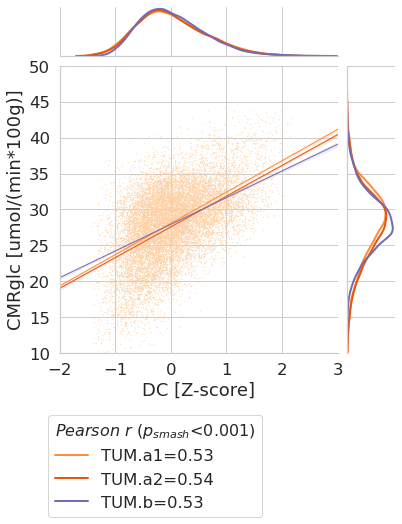

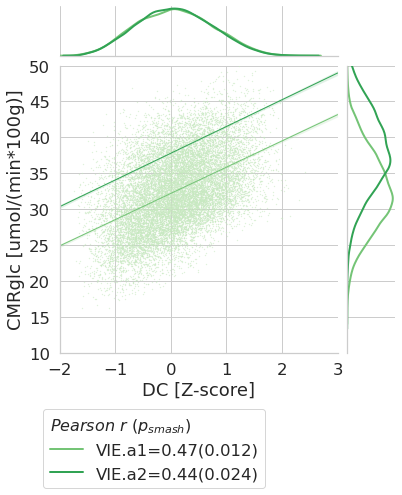

In [9]:
palette_regplot_index = 5
for site in list(cohorts_metadata.keys()):#[:-1]:#cohorts_metadata.keys():#
    filtered_index_lists = []
    np_null_dists = []
    filter_labels = []
    palette_regplot = []
    for cix,coh in enumerate(sorted(cohorts_metadata[site].keys())):
        cohort = f'{site}.{coh}'
        filtered_index_lists += [all_avg_vox_vals.cohort==cohort]
        np_null_dists += [cohorts_metadata[site][coh]['smash_{}-{}'.format(x_var,y_var)]]
        filter_labels += [cohort]
        if cix<2:
            palette_regplot += [plt.cm.tab20c([palette_regplot_index-cix]).flatten()]
        else:
            palette_regplot += [plt.cm.tab20c([palette_regplot_index+7]).flatten()]
    src.functions.multiple_joinplot(all_avg_vox_vals,x_var,y_var,filtered_index_lists,np_null_dists,filter_labels,palette_regplot,
                      plt.cm.tab20c([palette_regplot_index+2]).flatten(),
                      xlabel=xlabel,ylabel=ylabel,xlim=(-2,3),ylim=(10,50),legend_bbox_to_anchor=(-0.07,-0.6) if site=='TUM' else (-0.09,-0.5))
    palette_regplot_index += 4

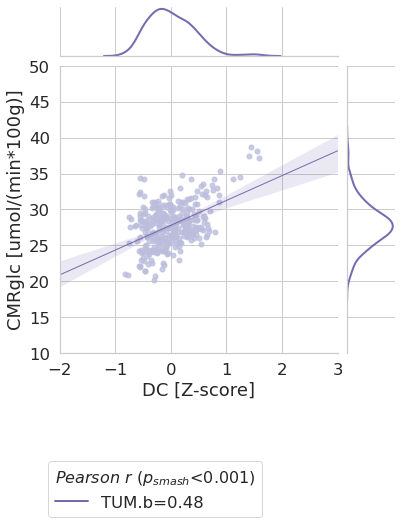

In [12]:
#SHow that the relationship is linear
palette_regplot_index = 12 #12 for tum.b 5 for TUM.a1
for site in list(cohorts_metadata.keys())[:1]:#[:-1]:#cohorts_metadata.keys():#
    filtered_index_lists = []
    np_null_dists = []
    filter_labels = []
    palette_regplot = []
    for cix,coh in enumerate(sorted(cohorts_metadata[site].keys())[-1:]):
        cohort = f'{site}.{coh}'
        filtered_index_lists += [all_avg_roi_vals.cohort==cohort]
        np_null_dists += [cohorts_metadata[site][coh]['smash_{}-{}'.format(x_var,y_var)]]
        filter_labels += [cohort]
        if cix<2:
            palette_regplot += [plt.cm.tab20c([palette_regplot_index-cix]).flatten()]
        else:
            palette_regplot += [plt.cm.tab20c([palette_regplot_index+7]).flatten()]
    src.functions.multiple_joinplot(all_avg_roi_vals,x_var,y_var,filtered_index_lists,np_null_dists,filter_labels,palette_regplot,
                      plt.cm.tab20c([palette_regplot_index+2]).flatten(),s=25,
                      xlabel=xlabel,ylabel=ylabel,xlim=(-2,3),ylim=(10,50),legend_bbox_to_anchor=(-0.07,-0.6) if site=='TUM' else (-0.09,-0.5))
    palette_regplot_index += 4

#### Individual level

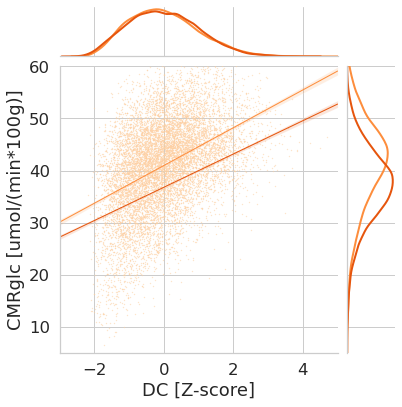

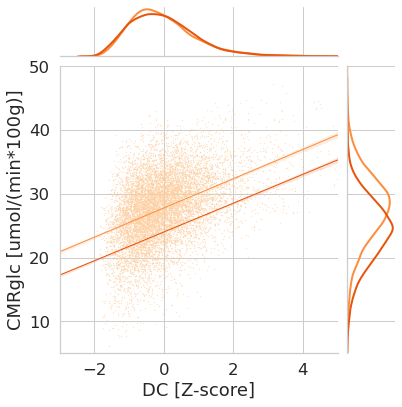

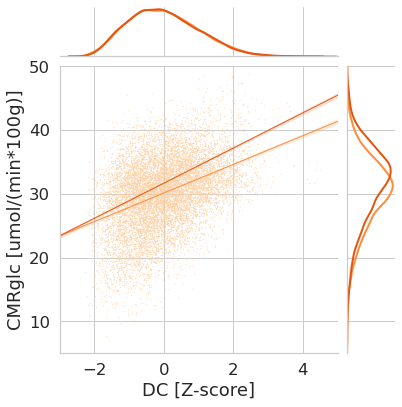

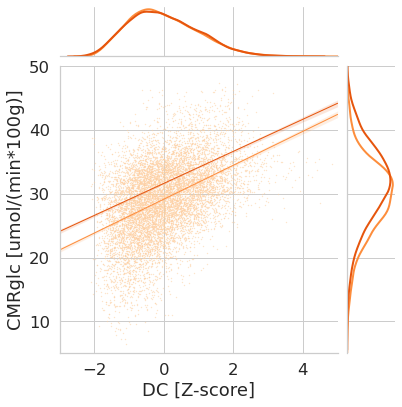

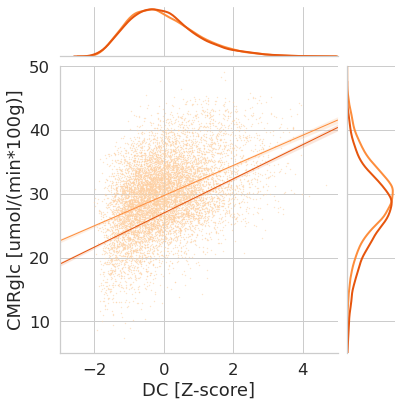

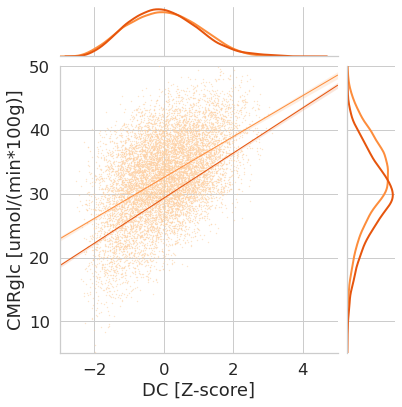

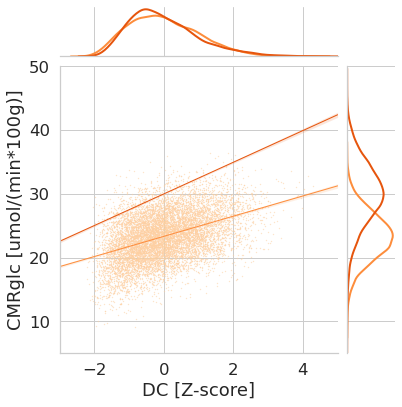

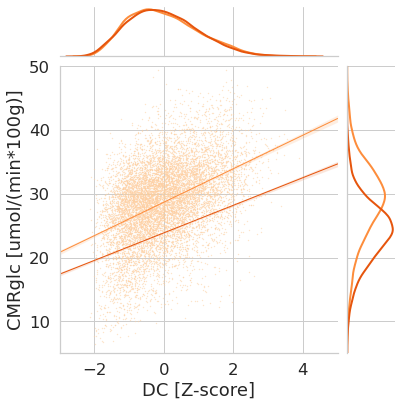

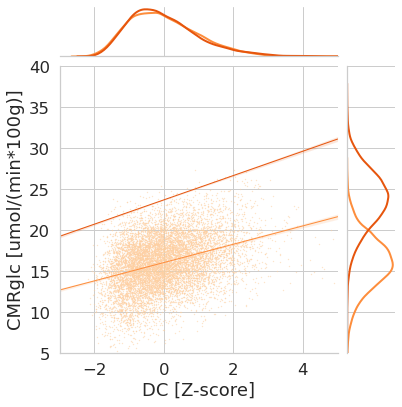

In [17]:
selected_df = all_ind_vox_vals #all_mm_vox_df
s = 0.1 #25 #
selected_site = 'TUM'
coh0 = 'a1'
coh1 = 'a2'
selected_site_sids = list(np.unique(cohorts_metadata[selected_site][coh0]['sids']+cohorts_metadata[selected_site][coh1]['sids']))
s1 = f'{selected_site}.{coh0}'
s2 = f'{selected_site}.a2'
scatter_color = plt.cm.tab20c([7]).flatten() if selected_site=='TUM' else plt.cm.tab20c([11]).flatten()#
if((selected_site=='TUM') & (coh0=='b')):
    scatter_color = plt.cm.tab20c([14]).flatten()
    selected_site_sids = cohorts_metadata[selected_site]['b']['sids']
for sid in selected_site_sids:#list(cohorts_metadata[selected_site]['a1']['sids']):
    subj_id = cohorts_metadata[selected_site][coh0]['sub_pref'] % sid
    ylim=(5,50) if sid not in [3,26,33] else (5,60)
    if sid in [26,28,31,34,36]: ylim=(5,40)
    if ((selected_site=='VIE') & (sid not in [4,9,12,14])): ylim=(10,65)
    selected_coh = s1 if sid in cohorts_metadata[selected_site][coh0]['sids'] else s2
    filtered_index = [((selected_df.cohort==selected_coh) & (selected_df.sid==subj_id))]
    smash_dists = [cohorts_metadata[selected_site][selected_coh.split('.')[1]]['individual_smash'][sid][f'smash_{x_var}-{y_var}']]
    cohorts_list = [s1,s2]
    color_list = [cohorts_metadata[selected_site][coh0]['color'],cohorts_metadata[selected_site][coh1]['color']]
    if((sid in cohorts_metadata[selected_site][coh1]['sids']) & (sid in cohorts_metadata[selected_site][coh0]['sids'])):
        filtered_index+=[((selected_df.cohort==s2) & (selected_df.sid==subj_id))]
        smash_dists+=[cohorts_metadata[selected_site][coh1]['individual_smash'][sid][f'smash_{x_var}-{y_var}']]
        src.functions.multiple_joinplot(selected_df,x_var,y_var,filtered_index,smash_dists,cohorts_list,color_list,scatter_color,
                      #[plt.cm.tab20c([5]).flatten(),plt.cm.tab20c([4]).flatten()],plt.cm.tab20c([7]).flatten(),
                          xlabel=xlabel,ylabel=ylabel,xlim=(-3,5),ylim=ylim,legend_bbox_to_anchor=(-0.09,-0.5),plot_legend=False,s=s)
    elif(sid in cohorts_metadata[selected_site][coh1]['sids']):
        filtered_index=[((selected_df.cohort==s2) & (selected_df.sid==subj_id))]
        smash_dists=[cohorts_metadata[selected_site][coh1]['individual_smash'][sid][f'smash_{x_var}-{y_var}']]
        src.functions.multiple_joinplot(selected_df,x_var,y_var,filtered_index,smash_dists,cohorts_list[1:],color_list[1:],scatter_color,
                      #[plt.cm.tab20c([5]).flatten(),plt.cm.tab20c([4]).flatten()],plt.cm.tab20c([7]).flatten(),
                          xlabel=xlabel,ylabel=ylabel,xlim=(-3,5),ylim=ylim,legend_bbox_to_anchor=(-0.09,-0.5),plot_legend=False,s=s)
    else:
        src.functions.multiple_joinplot(selected_df,x_var,y_var,filtered_index,smash_dists,cohorts_list[:1],color_list[:1],scatter_color,
                          xlabel=xlabel,ylabel=ylabel,xlim=(-3,5),ylim=ylim,legend_bbox_to_anchor=(-0.09,-0.5),plot_legend=False,s=s)
 

### bin

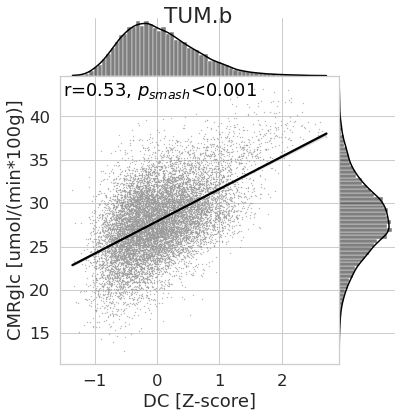

In [ ]:
#list(cohorts_metadata.keys())[:-1] when site ='all' is already included
for site in list(cohorts_metadata.keys())[:1]:#[:-1]:#cohorts_metadata.keys():#list(cohorts_metadata.keys())[:1]:#
    for coh in list(cohorts_metadata[site].keys())[:1]:#cohorts_metadata[site].keys():#list(cohorts_metadata[site].keys())[:1]:#
        project_id = cohorts_metadata[site][coh]['project_id']
        session = cohorts_metadata[site][coh]['session']
        version = cohorts_metadata[site][coh]['version']
        total_n_subj += cohorts_metadata[site][coh]['n_subj']
        cpac_dir = os.path.join(root_dir,project_id,fc_res_label,session)
        ses_dir = os.path.join(root_dir,project_id,session)
        if all_avg_vox_vals.size==0:
            cpac_dir = os.path.join('../../../',project_id,fc_res_label,session)
            ses_dir = os.path.join('../../../',project_id,session)
            gm_mask_pref = 'mean_'+session+'_segment_seg_1_'+thr_i+'_mni-'+vol_res+'_'+atlas_suf+version
            gx_gm_mask_fn = os.path.join(cpac_dir,gm_mask_pref+'.nii.gz')
            pet_fn = os.path.join(ses_dir,'all_'+session+'_1.3.12.2_itr-4_trimmed-upsampled-scale-2'+recon_tag+'_mcf'+smooth_suf+'_quant-cmrglc_acq-'+str(qx_t0)+str(qx_tend)+'min'+pvc+'_mni-'+vol_res+version+'.nii.gz')
            if conn_metric=='degree':
                fmri_fn = os.path.join(cpac_dir,'all_'+session+'_'+conn_metric+'_centrality_{}_mnireg-{}_gm-{}'.format(dc_type,vol_res,thr_i)+freq_band+GSR+dyn_wc+sthr_suf+smooth_suf+z_suff+version+'.nii.gz')# 
            elif conn_metric=='shannon_entropy':
                fmri_fn = os.path.join(cpac_dir,'all_'+session+'_'+conn_metric+'_bits{}_mni-{}{}.nii.gz'.format(smooth_suf,vol_res,version))
            elif conn_metric=='alff':
                fmri_fn = os.path.join(cpac_dir,'all_'+session+'_'+conn_metric+'_mnireg-{}_gm-{}'.format(vol_res,thr_i)+z_suff+version+freq_band+'.nii.gz')
            sd_fn = os.path.join(ses_dir,'all_'+session+'_signden_1.3.12.2_itr-4_trimmed-upsampled-scale-2'+recon_tag+'_mcf'+smooth_suf+'_quant-cmrglc_acq-'+str(qx_t0)+str(qx_tend)+'min'+pvc+'_mni-'+vol_res+version+sthr_suf+'.nii.gz')
            rois_fn = os.path.join(cpac_dir,gm_mask_pref+'_rois.nii.gz')
            avg_vox_vals_dict = src.functions.read_mask_nii(gx_gm_mask_fn,roi_labels=['roi_id'],z_score=True,cmrglc=pet_fn,degree=fmri_fn,roi_id=rois_fn)#,signal_density=sd_fn
            avg_vox_vals_dict['roi_id'][avg_vox_vals_dict['roi_id']>180] = avg_vox_vals_dict['roi_id'][avg_vox_vals_dict['roi_id']>180] - 20
            avg_vox_vals_dict['nw'] = np.vectorize(atlas_dict['roi2network'].get)(avg_vox_vals_dict['roi_id']).flatten()
            non_none_index = ((~np.in1d(avg_vox_vals_dict['nw'],ignore_nws)) & (avg_vox_vals_dict[conn_metric]>0) & (~np.isnan(avg_vox_vals_dict[conn_metric])))
            avg_vox_vals_dict['cohort'] = f'{site}.{coh}'
            avg_vox_vals_dict['vox_id'] = np.arange(len(non_none_index))
            

#            all_ineff_file = os.path.join(ses_dir,'all_'+session+'_signden_1.3.12.2_itr-4_trimmed-upsampled-scale-2'+recon_tag+'_mcf'+smooth_suf+'_quant-cmrglc_acq-'+str(qx_t0)+str(qx_tend)+'min'+pvc+'_mni-'+vol_res+version+sthr_suf+'.nii.gz')
#            if not os.path.exists(all_ineff_file):
#                avg_ineff = np.array([])
#                for sid in cohorts_metadata[site][coh]['sids']:
#                    sess_id = (cohorts_metadata[site][coh]['sub_pref']+'-'+session) % sid
#                    sid_dir =  os.path.join(root_dir,project_id,session,'pet',sess_id,'niftypet'+recon_label)
#                    avg_ineff_tmp = gx_gm_masker.fit_transform(os.path.join(sid_dir,'signden{}-{}{}_mcf{}_quant-{}_acq-{}{}min{}_gm-{}{}.nii.gz'.format(x_var,y_var,recon_tag,smooth_suf,pet_metric,qx_t0,qx_tend,pvc_suf,thr_i,sthr_suf))).flatten()
#                    avg_ineff = avg_ineff_tmp[np.newaxis,:] if not avg_ineff.size else np.concatenate((avg_ineff,avg_ineff_tmp[np.newaxis,:]),axis=0)
#            else:
#                avg_ineff = gx_gm_masker.fit_transform(all_ineff_file)                
#            avg_ineff[avg_ineff==0]=np.nan
#            avg_ineff = np.nanmean(avg_ineff,axis=0)
#            n_vox = avg_ki.shape[0]
#            if nmad:
#                non_none_index = ((~np.in1d(yeo_labels,['Other','None',None,'Limbic'])) & (met_val>0) & (~np.isnan(met_val)))
#                vals_med = np.nanmedian(met_val[non_none_index])
#                vals_mad = stats.median_absolute_deviation(met_val[non_none_index],nan_policy='omit')
#                vals_max = np.nanmax(met_val[non_none_index])
#                print((vals_med+nmad*vals_mad))
#                print((vals_med-nmad*vals_mad))
#                met_z_val[(met_val>(vals_med+nmad*vals_mad)) | (met_val<(vals_med-nmad*vals_mad))] = np.nan
#                met_val[(met_val>(vals_med+nmad*vals_mad)) | (met_val<(vals_med-nmad*vals_mad))] = np.nan      
#
#            non_none_index = ((~np.in1d(yeo_labels,['Other','None',None,'Limbic'])) & (met_val>0) & (~np.isnan(met_val)))
#            if 'non_none_index'.format(x_var,y_var) not in cohorts_metadata[site][coh].keys():
#                cohorts_metadata[site][coh]['non_none_index'] = non_none_index    
#            avg_vox_vals =  pd.DataFrame({conn_metric:met_val[non_none_index],
#                                          conn_metric+'_z':met_z_val[non_none_index],
#                                          pet_metric:avg_ki[non_none_index],
#                                          'nw':yeo_labels[non_none_index],
#                                          'roi_id':yeo_rois[non_none_index],
#                                          'module':consmod_labels[non_none_index],
#                                          'signal_density':avg_ineff[non_none_index],
#                                          'session':session,
#                                          'cohort':'{}.{}'.format(site,coh)#,
##                                          'vox_id':np.arange(len(non_none_index))
#                                         })
#            avg_vox_vals['expansion'] = avg_vox_vals['roi_id'].map(external_datasets['expansion']['mmp_map'])
#            avg_vox_vals['expansion_type'] = avg_vox_vals['roi_id'].map(external_datasets['expansion']['categories'])
#            if x_var==pet_metric: avg_vox_vals['signal_density'] = -1*avg_vox_vals['signal_density']
#        
#            if (conn_metric=='dti'): avg_vox_vals.loc[avg_vox_vals[conn_metric]>3,conn_metric] = np.nan
#            if (conn_metric=='gmvar'): 
#                vals_med = avg_vox_vals[conn_metric].median()
#                vals_std = avg_vox_vals[conn_metric].std()
#                avg_vox_vals.loc[(avg_vox_vals[conn_metric]>(vals_med+.5*vals_std)) | (avg_vox_vals[conn_metric]<(vals_med-.5*vals_std)),conn_metric] = np.nan
#            elif calc_z:
#                avg_vox_vals.loc[~np.isnan(avg_vox_vals[conn_metric]),conn_metric] = stats.zscore(avg_vox_vals.loc[~np.isnan(avg_vox_vals[conn_metric]),conn_metric])
#        
#            all_avg_vox_vals = pd.concat([all_avg_vox_vals,avg_vox_vals], ignore_index=True)
#            
#            avg_roi_vals = avg_vox_vals.groupby(['roi_id'], as_index=False).mean()
#            avg_roi_vals['nvox_per_roi']=avg_vox_vals.groupby(['roi_id'], as_index=False).count()[pet_metric].to_numpy()
#            avg_roi_vals['roi_id'] = avg_roi_vals['roi_id'].astype(int)
#            avg_roi_vals = avg_roi_vals.merge(comm_df, on = 'roi_id', how = 'left')
#            avg_roi_vals=avg_roi_vals[avg_roi_vals['roi_id']!=0]
#            avg_roi_vals['nw'] = avg_roi_vals['roi_id'].map(atlas_dict['roi2network'])
#            avg_roi_vals['module'] = avg_roi_vals['roi_id'].map(mmp2consmod_dict)
#            avg_roi_vals['session'] = session
#            avg_roi_vals['cohort'] = '{}.{}'.format(site,coh)
#            all_avg_roi_vals = pd.concat([all_avg_roi_vals,avg_roi_vals], ignore_index=True)
#        
#            if conn_metric!='dti':    
#                avg_vox_vals.loc[avg_vox_vals['nw'] == 'None','nw'] = np.nan
#        else:
#        avg_vox_vals = all_avg_vox_vals[all_avg_vox_vals.cohort=='{}.{}'.format(site,coh)].copy()
#        avg_roi_vals = all_avg_roi_vals[all_avg_roi_vals.cohort=='{}.{}'.format(site,coh)].copy()
#        if ('smash_{}-{}'.format(x_var,y_var) not in cohorts_metadata[site][coh].keys()):
#            cohorts_metadata[site][coh]['smash_{}-{}'.format(x_var,y_var)] = src.functions.smash_comp(metric2mmp(avg_vox_vals,x_var,'roi_id'),metric2mmp(avg_vox_vals,y_var,'roi_id'),
#                                                                                        lh_dist_full,l=5,u=95,n_mad='min',p_uthr=0.05,plot=False,
#                                                                                        y_nii_fn=remove_ext(avg_ki_file.replace('all','mean')) if y_var==pet_metric else remove_ext(avg_met_file.replace('all','mean')))
#
#        r_param,p_param=stats.pearsonr(avg_vox_vals.loc[avg_vox_vals[conn_metric].notnull(),x_var],avg_vox_vals.loc[avg_vox_vals[conn_metric].notnull(),y_var])
#        if len(cohorts_metadata[site][coh]['smash_{}-{}'.format(x_var,y_var)])>0:
#            p_np = nonparp(r_param, cohorts_metadata[site][coh]['smash_{}-{}'.format(x_var,y_var)])
#            p_np = p_np if p_np>0 else 0.00001
#            g = src.functions.plot_joint(avg_vox_vals[x_var],avg_vox_vals[y_var],s=s,robust=False,kdeplot=False,truncate=True,xlim0=False,
#                           y_label=ylabel,x_label=xlabel,return_plot_var=True,p_smash=p_np)
#        else:
#            g = src.functions.plot_joint(avg_vox_vals[x_var],avg_vox_vals[y_var],s=s,robust=False,kdeplot=False,truncate=True,xlim0=False,y_label=ylabel,x_label=xlabel,return_plot_var=True)
#        plt.suptitle('{}.{}'.format(site,coh))
#        if plot_signden:
#            sns.scatterplot(x=x_var, y=y_var, hue='signal_density', #alpha=0.75,
#                data=avg_vox_vals,linewidth=0,s=1.5,legend=False,palette=sel_cm,
#                vmin=avg_vox_vals.signal_density.quantile(0.25),vmax=avg_vox_vals.signal_density.quantile(0.75),ax=g.ax_joint)
#            plot_surf(metric2mmp(avg_vox_vals,'signal_density','roi_id'), 
#                      os.path.join(root_dir,project_id,session,'pet','{}.{}_signden'.format(site,coh)),
#                      cmap=ListedColormap(extended_cm),colorbar=True,vlow=5,vhigh=95,fig_title='Signal density {}.{}'.format(site,coh)) 
#        if plot_mod_maps:
#            plot_surf(metric2mmp(avg_vox_vals,x_var,'roi_id'), 
#                      os.path.join(root_dir,project_id,session,'pet','{}.{}_{}'.format(site,coh,x_var)),
#                      cmap=ListedColormap(np.concatenate((np.array([[0.5,0.5,0.5,1.0]]),getattr(plt.cm,'viridis')(np.arange(0,getattr(plt.cm,'viridis').N))))),
#                      colorbar=True,vlow=10,vhigh=90,fig_title='{} {}.{}'.format(x_var,site,coh))
#            plot_surf(metric2mmp(avg_vox_vals,y_var,'roi_id'), 
#                      os.path.join(root_dir,project_id,session,'pet','{}.{}_{}'.format(site,coh,y_var)),
#                      cmap=ListedColormap(np.concatenate((np.array([[0.5,0.5,0.5,1.0]]),getattr(plt.cm,'cividis')(np.arange(0,getattr(plt.cm,'cividis').N))))),
#                      colorbar=True,vlow=10,vhigh=90,fig_title='{} {}.{}'.format(y_var,site,coh))
#            
##!        plt.figure(figsize=(2,5))
##!        plot_rnd_dist(cohorts_metadata[site][coh]['smash'],r_param,p_np,plt.gca(),xlabel=conn_metric.upper(),print_text=False)
#        plt.figure(figsize=(3,3))
#        avg_vox_vals['residual'] = pg.linear_regression(avg_vox_vals[x_var],avg_vox_vals[y_var],coef_only=False,remove_na=True,as_dataframe=False)['residuals']
#        sns.scatterplot(x_var,'residual',data=avg_vox_vals,s=3*s,legend=False,hue='residual', palette=sel_cm,
#                        vmin=avg_vox_vals.residual.quantile(0.25),vmax=avg_vox_vals.residual.quantile(0.75))#color=(0.6,0.6,0.6))#,hue='expansion_type', palette='Spectral_r'
#        sd_res_roi_df = pd.concat([sd_res_roi_df,avg_vox_vals.groupby(['cohort','roi_id'], as_index=False).mean()[['cohort','roi_id','residual',x_var]]], ignore_index=True) 
#        #
#        plt.gca().set_xlabel(xlabel)
#        plt.gca().set_ylabel('residual')
#        if plot_expansion:
#            exp_thr = np.log(external_datasets['expansion']['data'][:180]) if expresion_log else external_datasets['expansion']['data'][:180]
#            #exp_thr[external_datasets['expansion']['data'][:180]<2.05]=np.min(exp_thr)
#            sd_180rois = metric2mmp(avg_vox_vals,'signal_density','roi_id')
#            if 'smash_sd_{}-{}'.format(x_var,y_var) not in cohorts_metadata[site][coh].keys():
#                cohorts_metadata[site][coh]['smash_sd_{}-{}'.format(x_var,y_var)] = smash_comp(sd_180rois,exp_thr,lh_dist_full,y_nii_fn=os.path.join(img_dir,'expansion_wei2019.png'),l=5,u=95,n_mad=3,
#                                                                                               xlabel='Signal density\n[umol/(min*100g)]' if y_var==pet_metric else 'Signal density', ylabel='Brain expansion',
#                                                                                               p_uthr=1,plot=True,cmap=ListedColormap(extended_cm),print_text=False,plot_rnd=False,plot_surface=False)
#            else:
#                smash_comp(sd_180rois,exp_thr,lh_dist_full,y_nii_fn=os.path.join(img_dir,'expansion_wei2019.png'),l=5,u=95,n_mad='min',
#                           xlabel='Signal density\n[umol/(min*100g)]' if y_var==pet_metric else 'Signal density', ylabel='Brain expansion',
#                           p_uthr=1,plot=True,cmap=ListedColormap(extended_cm),print_text=True,plot_rnd=True,plot_surface=True,
#                           x_surr_corrs=cohorts_metadata[site][coh]['smash_sd_{}-{}'.format(x_var,y_var)])
#
#if save_df:
#    all_avg_roi_vals.to_csv(os.path.join(root_dir,'fdgquant2016','gx_all-cohorts_roi_nsubj-{}_{}-{}_v1.0.csv'.format(total_n_subj,conn_metric,dc_type)),index=False)
#    all_avg_vox_vals.to_csv(os.path.join(root_dir,'fdgquant2016','gx_all-cohorts_vox_nsubj-{}_{}-{}_v1.0.csv'.format(total_n_subj,conn_metric,dc_type)),index=False)
#

In [ ]:
import src.functions

In [ ]:
%load_ext autoreload
%autoreload 2